<a href="https://colab.research.google.com/github/235U92/hairloss/blob/main/vgg16ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install livelossplot

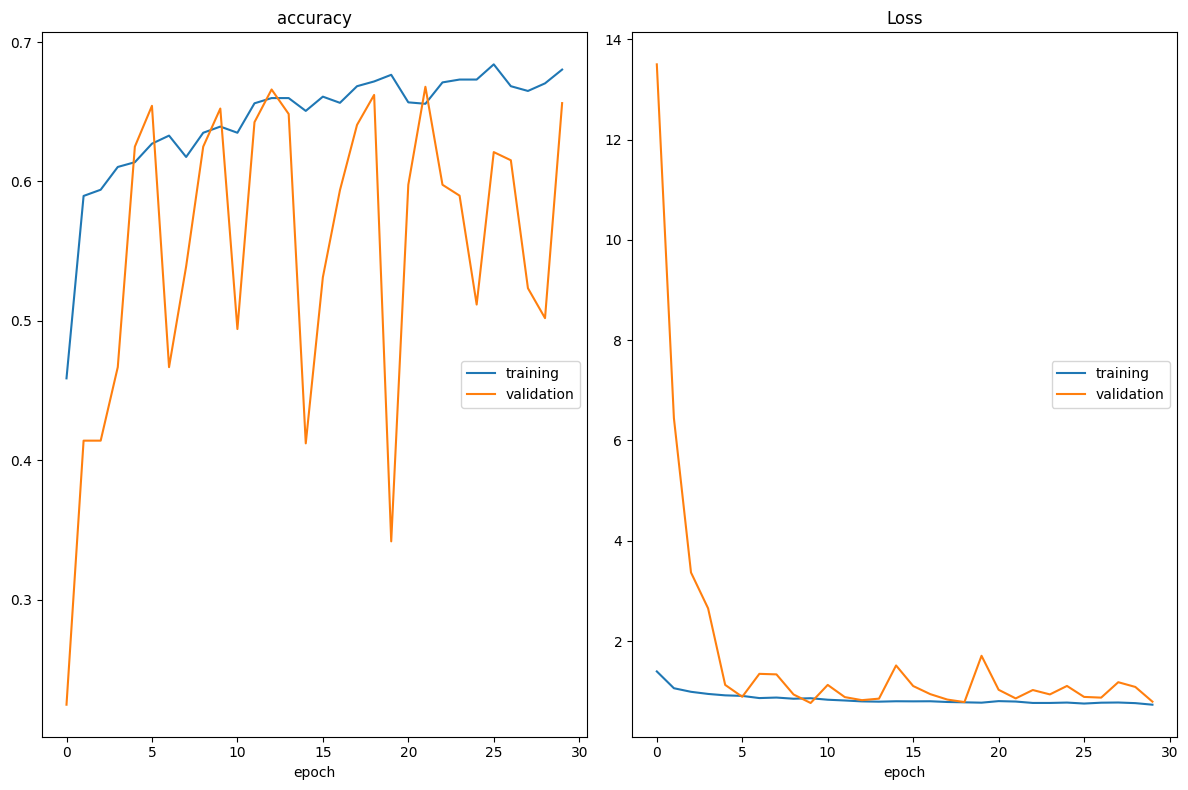

accuracy
	training         	 (min:    0.459, max:    0.684, cur:    0.680)
	validation       	 (min:    0.225, max:    0.668, cur:    0.656)
Loss
	training         	 (min:    0.732, max:    1.396, cur:    0.732)
	validation       	 (min:    0.766, max:   13.498, cur:    0.793)
46/46 [==============================] - 63s 1s/step - loss: 0.7319 - accuracy: 0.6803 - val_loss: 0.7926 - val_accuracy: 0.6562


In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback
from keras.layers import BatchNormalization, ReLU

BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.8, 1.2],
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

train_data_dir = '/content/drive/MyDrive/imagedata'
test_data_dir = '/content/drive/MyDrive/imagedata2'


traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = True

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096,kernel_initializer='he_normal')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = ReLU()(top_model)
    top_model = Dense(1072, kernel_initializer='he_normal')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = ReLU()(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=4

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 200

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/vgg16_nft3.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')


vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)



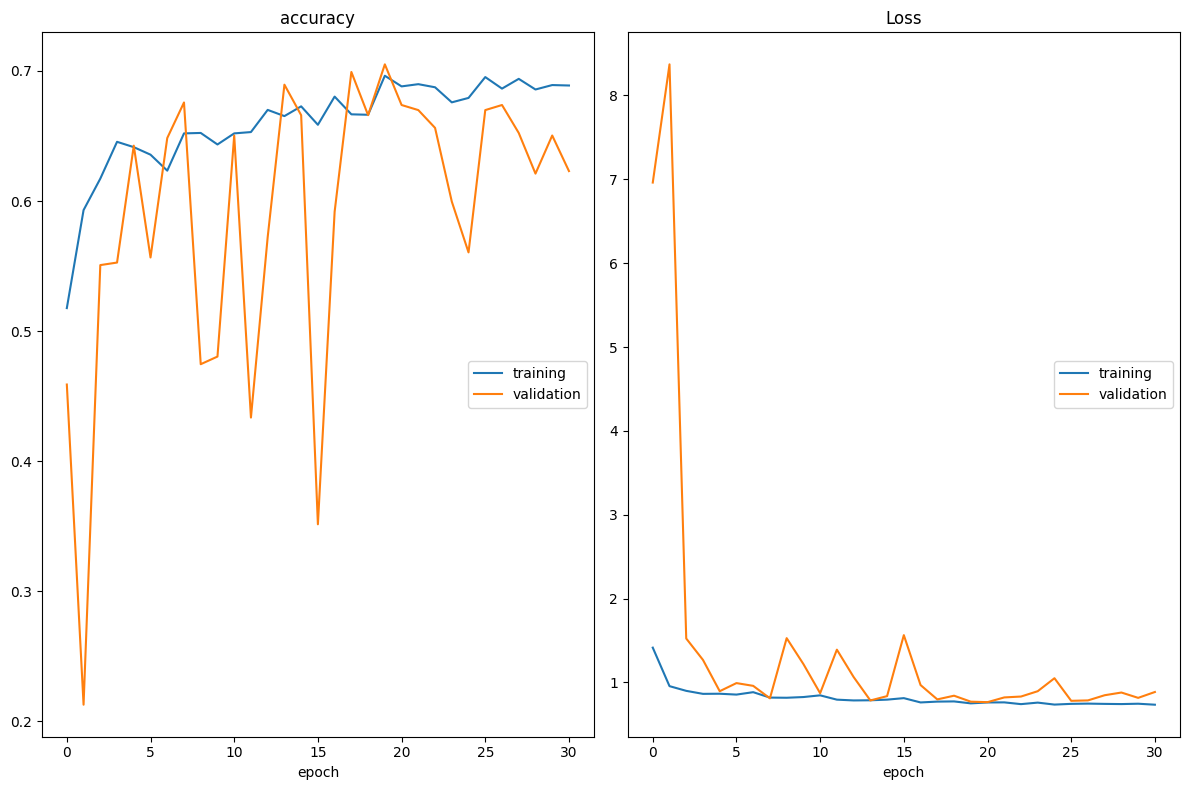

accuracy
	training         	 (min:    0.518, max:    0.696, cur:    0.689)
	validation       	 (min:    0.213, max:    0.705, cur:    0.623)
Loss
	training         	 (min:    0.735, max:    1.415, cur:    0.735)
	validation       	 (min:    0.765, max:    8.371, cur:    0.886)
46/46 [==============================] - 63s 1s/step - loss: 0.7347 - accuracy: 0.6888 - val_loss: 0.8862 - val_accuracy: 0.6230


In [ ]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=5)

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_model.load_weights('/content/drive/MyDrive/vgg16_nft3.h5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc * 100))


첫번째 65
두번째 false 58프로
세번째 true 48프

742/742 [==============================] - 595s 802ms/step
VGG16 Model Accuracy with Fine-Tuning: 48.92%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn

df = pd.read_excel("/content/drive/MyDrive/df.xlsx", engine = "openpyxl")

X_train, X_test, Y_train, Y_test = train_test_split(df.drop('target', axis=1), df['target'],  test_size=0.3, random_state=1636)
dtree = DecisionTreeClassifier(criterion='entropy',random_state=1636, max_depth=4)
dtree.fit(X_train, Y_train)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=1636, splitter='best')
dtree.predict( X_test)

pd.crosstab(dtree.predict( X_test), Y_test)


target,0,1,2,3
row_0,,,,
0,519,0,0,0
1,55,1452,106,0
2,0,0,900,7


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(dtree.predict( X_test), Y_test)



0.9447186574531096

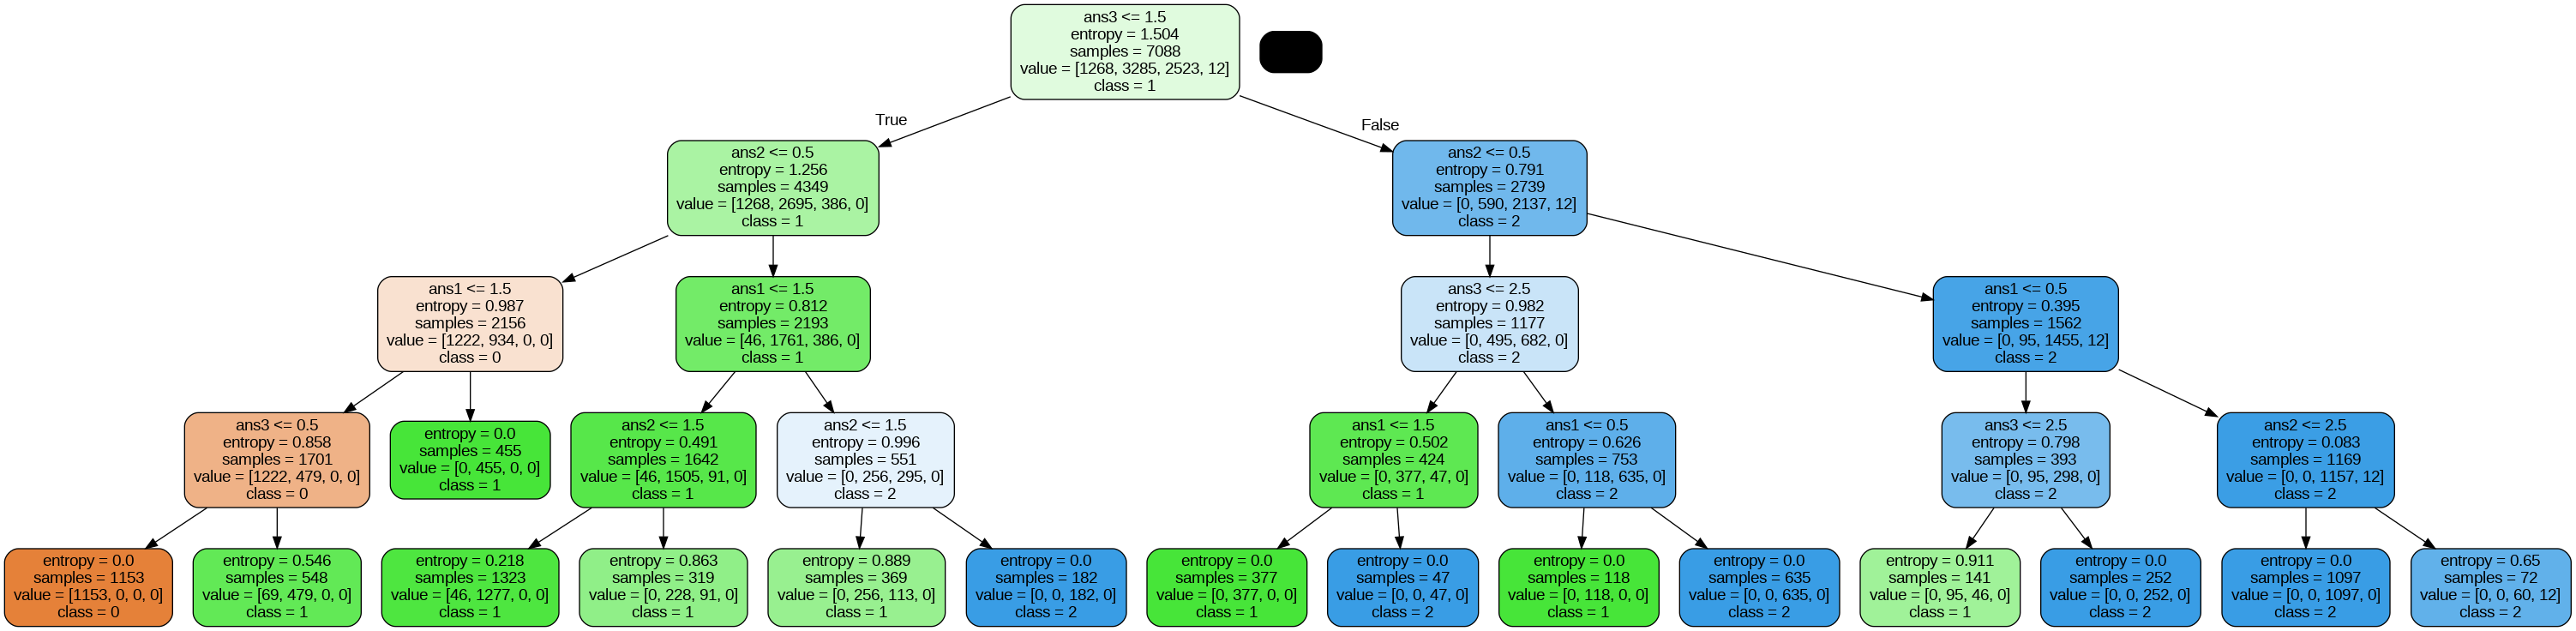

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(dtree, out_file=None, feature_names=X_train.columns, class_names=[ '0' ,'1', '2','3'], filled=True,  impurity=True, rounded=True)
graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
